In [1]:
import numpy as np
import pandas as pd
import math as m
import sympy as sym
import random as rand
import matplotlib.pyplot as plt
import cmath as cm
from tqdm import tqdm

In [2]:
# defininf the states
# defininsg coefficeients sybols

def Creating_states(coeff, Abstract = False):    # coeff list like [a0,a1,b0,b1]
    if Abstract == True:
        a0 = sym.symbols('a0')
        a1 = sym.symbols('a1')
        b0 = sym.symbols('b0')
        b1 = sym.symbols('b1')
    else:
        a0 = coeff[0]
        a1 = coeff[1]
        b0 = coeff[2]
        b1 = coeff[3]
    psi0 = [a0,a1]      # defining states
    psi1 = [b0,b1]
    return([psi0,psi1])

In [3]:
# creating the SIC POVM matrices
w = m.e**((2/3)*m.pi*(1j))
POVM_vec = (1/(2**.5))*(np.array([[0,1,-1],[-1,0,1],[1,-1,0],[0,w,-w**2],[-1,0,w**2],[1,-w,0],[0,w**2,-w],[-1,0,w],[1,-w**2,0]]))  # an array of POVM direction vectors
POVM_elts = [(1/3)*np.outer(np.conjugate(POVM_vec[i]),POVM_vec[i]) for i in range(len(POVM_vec))]   # a list of POVM matrix

M = [[np.trace(np.dot(POVM_elts[i],POVM_elts[j])) for i in range(len(POVM_elts))] for j in range(len(POVM_elts))]     # creating M matrix using POVM definition

u_0 = [1/3 for i in range(9)]           # cerating u_0 vector, to create the inverse matrix
M_inv = 3*np.outer(u_0,u_0) + 12*(np.eye(9) - np.outer(u_0,u_0))        # creating the inverse matrix


In [4]:
# creating the POVM matrices for Englert method

sigma = 0
tau = 0
M = np.zeros((9,9))
POVM_eng = np.zeros((9,9))

In [5]:
#Creating function for the deltarho error

def experiment_rho(N, coeff, priors, POVM_elts, M_inv):
    initial_states = Creating_states(Abstract=False, coeff = coeff)     # Creating the two states with these coefficients
    psi0 = initial_states[0]
    psi1 = initial_states[1]    # created the states to be discriminated

    psi0sq = []
    psi1sq = []
    [[psi0sq.append(i*j) for i in psi0] for j in psi0]
    [[psi1sq.append(i*j) for i in psi1] for j in psi1]   
    psi0psi0 = [psi0sq[0], (psi0sq[1]**2+psi0sq[2]**2)**(.5), psi0sq[3]]    
    psi1psi1 = [psi1sq[0], (psi1sq[1]**(2)+psi1sq[2]**(2))**(.5), psi1sq[3]]    # creating square states
    
    vec_psi0psi0 = np.array(psi0psi0)     
    vec_psi1psi1 = np.array(psi1psi1)
    rho = priors[0]*np.outer(vec_psi0psi0, vec_psi0psi0)+ priors[1]*np.outer(vec_psi1psi1, vec_psi1psi1)     # theoretical density matrix with priors 1/2 each.

    prob_vec =  [np.trace(np.dot(POVM_elts[i],rho)) for i in range(9)] 
    prob_vec = [i.real for i in prob_vec if abs(i.imag) < .01]          # cleaned up theoretical prob vector

    POVM_dir_symbols = ['d1','d2','d3','d4','d5','d6','d7','d8','d9']      # symbols to indicate collapsed direction
    #prob distribution is simply the corresponding elements of the prob_vec
    collapse_dir_vec = rand.choices(POVM_dir_symbols, weights=prob_vec, k = N)   # choosing collapse directions with weights for N trials

    nj_vec = [collapse_dir_vec.count(f'd{i+1}') for i in range(9)]
    pj_num_vec = [i/N for i in nj_vec]                                  # numerical prob vector     
    
    r_vec = np.dot(M_inv,pj_num_vec)
    
    # constructing the rho numrical using the r_vector etc.
    rho_num_list = [r_vec[i]*POVM_elts[i] for i in range(len(POVM_elts))]   # list of matrices, see equation 7 in Hillery notes pair_disc.pdf
    rho_num = np.zeros_like(rho_num_list[0])
    for matrix in rho_num_list:
        rho_num = np.add(rho_num, matrix)       # created the numerical rho
    
    del_rho = rho_num-rho 
    
    eigenvalues, eigenvectors = np.linalg.eig(del_rho)  # each COLUMN is the corresponding eigenvector and not the row. eigenvectors[:,0]
    # eigenvectors[:,0]   # eigenvector correspoding to the first eigenvalue
    evals = np.array([i.real for i in eigenvalues if abs(i.imag)< .001])
    norm_del_rho = max([abs(i) for i in evals])     # picking out the largest magnitude evalue
    error = norm_del_rho

    return error

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [03:13<00:00,  5.17it/s]


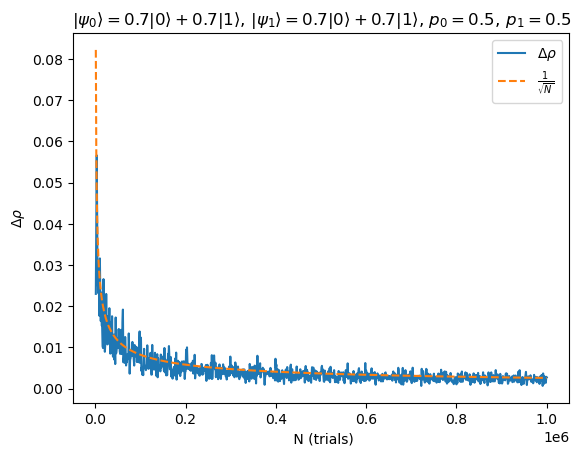

Error Converged to:  0.005048924134657231


In [6]:

coeff = [1/(2**.5),1/(2**.5),1/(2**.5),1/(2**.5)] #1/(2**.5)
priors = [.5,.5]
trials = [1000*(i+1) for i in range(1000)]

sqrtN  = [2.6/(i**.5) for i in trials]     # ideal square root shape with a constant multiplied for scaling
errors = [experiment_rho(i,coeff,priors,POVM_elts, M_inv) for i in tqdm(trials)]

plt.plot(trials, errors, label=r'$\Delta \rho $')
plt.plot(trials ,sqrtN, "--", label=r'$\frac{1}{\sqrt{N}}$')
plt.xlabel(' N (trials)')
plt.ylabel(r'$\Delta \rho $')
plt.title(r'$|\psi_0\rangle ={}|0\rangle+{}|1\rangle $, $|\psi_1\rangle ={}|0\rangle+{}|1\rangle $, $p_0={},\,p_1={}$'.format(round(coeff[0],1), round(coeff[1],1), round(coeff[2],1), round(coeff[3],1), priors[0], priors[1]))
plt.legend()

plt.show()

print(f'Error Converged to: ' , experiment_rho( 1000*100 ,coeff,priors,POVM_elts, M_inv))

In [18]:

#Creating function for the fidelity error

def solve_quadratic(a, b, c):

    if a == 0 and c == 0:
        sol1 = 0
        sol2 = 0

    dis = b * b - 4 * a * c 
    sqrt_val = m.sqrt(abs(dis))

    if dis > 0: 
        sol1 = (-b - sqrt_val)/(2 * a)
        sol2 = (-b + sqrt_val)/(2 * a)
     
    elif dis == 0: 
        sol1 = -b / (2 * a)
        sol2 = -b / (2 * a)
     
    # when discriminant is less than 0
    else:
        sol1 = - b / (2 * a) - 1j*sqrt_val/ (2 * a)
        sol2 = - b / (2 * a) + 1j*sqrt_val/ (2 * a)
    

    return sol1, sol2

def experiment_fid(N, coeff, priors, POVM_elts, M_inv):
    initial_states = Creating_states(Abstract=False, coeff = coeff)     # Creating the two states with these coefficients
    psi0 = initial_states[0]
    psi1 = initial_states[1]    # created the states to be discriminated

    #print(f'psi0: {psi0}, psi1: {psi1}')

    psi0sq = []
    psi1sq = []
    [[psi0sq.append(i*j) for i in psi0] for j in psi0]
    [[psi1sq.append(i*j) for i in psi1] for j in psi1]   
    psi0psi0 = [psi0sq[0], (psi0sq[1]**2+psi0sq[2]**2)**(.5), psi0sq[3]]    
    psi1psi1 = [psi1sq[0], (psi1sq[1]**(2)+psi1sq[2]**(2))**(.5), psi1sq[3]]    # creating square states
    
    vec_psi0psi0 = np.array(psi0psi0)     
    vec_psi1psi1 = np.array(psi1psi1)
    rho = priors[0]*np.outer(vec_psi0psi0, vec_psi0psi0)+ priors[1]*np.outer(vec_psi1psi1, vec_psi1psi1)     # theoretical density matrix with priors 1/2 each.

    prob_vec =  [np.trace(np.dot(POVM_elts[i],rho)) for i in range(9)] 
    prob_vec = [i.real for i in prob_vec if abs(i.imag) < .01]          # cleaned up theoretical prob vector

    POVM_dir_symbols = ['d1','d2','d3','d4','d5','d6','d7','d8','d9']      # symbols to indicate collapsed direction
    #prob distribution is simply the corresponding elements of the prob_vec
    collapse_dir_vec = rand.choices(POVM_dir_symbols, weights=prob_vec, k = N)   # choosing collapse directions with weights for N trials

    nj_vec = [collapse_dir_vec.count(f'd{i+1}') for i in range(9)]
    pj_num_vec = [i/N for i in nj_vec]                                  # numerical prob vector     
    
    r_vec = np.dot(M_inv,pj_num_vec)
    
    # constructing the rho numrical using the r_vector etc.
    rho_num_list = [r_vec[i]*POVM_elts[i] for i in range(len(POVM_elts))]   # list of matrices, see equation 7 in Hillery notes pair_disc.pdf
    rho_num = np.zeros_like(rho_num_list[0])
    for matrix in rho_num_list:
        rho_num = np.add(rho_num, matrix)       # created the numerical rho
     
    eigenvalues, eigenvectors = np.linalg.eig(rho_num) 
    evals = np.array([i.real for i in eigenvalues if abs(i.imag)< .001])
    index = np.argmin(evals)
    eigenvector = eigenvectors[:,index]

    c00=eigenvector[0]
    c01=eigenvector[1]
    c01t=eigenvector[1]/m.sqrt(2)
    c11=eigenvector[2]

    f0,f1=solve_quadratic(c00, 2*c01t, c11)
    f0p,f1p=solve_quadratic(c11, 2*c01t, c00)

    #print(f'f0: {f0}, f1: {f1}, f0p: {f0p}, f1p: {f1p}')

    csi = np.asarray([c00,c01,c11])
    csi0 = abs(np.vdot(csi,psi0psi0))**2
    csi1 = abs(np.vdot(csi,psi1psi1))**2
    csis = [csi0,csi1]

        
    #all possible positive coeffs
    a1 = abs(f0)/(m.sqrt(1+ (abs(f0))**2))
    a2 = abs(f0p)/(m.sqrt(1+ (abs(f0p))**2))
    a3 = 1/(m.sqrt(1+ (abs(f0))**2))
    a4 = 1/(m.sqrt(1+ (abs(f0p))**2))
    a5 = abs(f1)/(m.sqrt(1+ (abs(f1))**2))
    a6 = abs(f1p)/(m.sqrt(1+ (abs(f1p))**2))
    a7 = 1/(m.sqrt(1+ (abs(f1))**2))
    a8 = 1/(m.sqrt(1+ (abs(f1p))**2))
    #all possible negative coeffs
    m1 = -a1
    m2 = -a2
    m3 = -a3
    m4 = -a4
    m5 = -a5
    m6 = -a6
    m7 = -a7
    m8 = -a8

    #list of all possible coeffs
    values = [a1,a2,a3,a4,a5,a6,a7,a8,m1,m2,m3,m4,m5,m6,m7,m8]

    #all possible numerical (normalized) wavefunctions
    pairs = [np.array([i, j])/np.linalg.norm([i, j]) for i in values for j in values]

    #all possible fidelities
    fid_psi0 = [abs(np.vdot(i, psi0))**2 for i in pairs]
    fid_psi1 = [abs(np.vdot(np.array(j), psi1))**2 for j in pairs]

    # Create the dictionaries for the fidelities and the corresponding num wavefunctions
    fid_psi0_dict = dict(zip(fid_psi0, pairs))
    fid_psi1_dict = dict(zip(fid_psi1, pairs))
    
    #find the max fidelity and the corresponding num wavefunction
    fid0 = max(fid_psi0_dict.keys())
    psi_num0 = fid_psi0_dict[fid0]
    fid1 = max(fid_psi1_dict.keys())
    psi_num1 = fid_psi1_dict[fid1]

    #print(f'fid0: {fid0}, fid1: {fid1}')
    #print(f'psi_0: {psi_num0_max}, psi_1: {psi_num1_max}')

    #extract p0 and p1 numerical from rho_num
    psi0sqn = []
    psi1sqn = []
    [[psi0sqn.append(i*j) for i in psi_num0] for j in psi_num0]
    [[psi1sqn.append(i*j) for i in psi_num1] for j in psi_num1]   
    psi0psi0n = [psi0sqn[0], (psi0sqn[1]**2+psi0sqn[2]**2)**(.5), psi0sqn[3]]    
    psi1psi1n = [psi1sqn[0], (psi1sqn[1]**(2)+psi1sqn[2]**(2))**(.5), psi1sqn[3]]    # creating square states
    vec_psi0psi0n = np.array(psi0psi0n)     
    vec_psi1psi1n = np.array(psi1psi1n)
    p0 = np.inner(vec_psi0psi0n,np.inner(rho_num, vec_psi0psi0n)) - priors[1]*abs(np.inner(vec_psi0psi0n,vec_psi1psi1n))**2
    p1 = np.inner(vec_psi1psi1n,np.inner(rho_num, vec_psi1psi1n)) - priors[0]*abs(np.inner(vec_psi1psi1n,vec_psi0psi0n))**2


    fid = [fid0,fid1]
    psin = [psi_num0,psi_num1]
    p = [p0,p1]

    return([fid,csis,csi,psin,p])


In [ ]:
'''     
    # Find the tuple that minimizes (x - psi0[0])**2 + (y - psi0[1])**2
    pairs = [[i, j] for i in values for j in values]
    min_value0 = min(pairs, key=lambda x: (x[0] - psi0[0])**2 + (x[1] - psi0[1])**2)
    # Find the tuple that minimizes (x - psi1[0])**2 + (y - psi1[1])**2
    min_value1 = min(pairs, key=lambda x: (x[0] - psi1[0])**2 + (x[1] - psi1[1])**2)
    psi_num0 = list(min_value0)
    psi_num1 = list(min_value1)

    norm0 = np.linalg.norm(psi_num0)
    norm1 = np.linalg.norm(psi_num1)

    psi_num0_norm = psi_num0/norm0
    psi_num1_norm = psi_num1/norm1

    fid0 = abs(np.vdot(psi_num0_norm,psi0))**2
    fid1 = abs(np.vdot(psi_num1_norm,psi1))**2
'''

        
''' # Find the value closest to psi0,1[0,1], norm L2
    
    values = [a0,a1,b0,b1,a0p,a1p,b0p,b1p]
    cs_a0 = min(values, key=lambda x: (x - psi0[0])**2)
    cs_a1 = min(values, key=lambda x: (x - psi0[1])**2)
    cs_b0 = min(values, key=lambda x: (x - psi1[0])**2)
    cs_b1 = min(values, key=lambda x: (x - psi1[1])**2)
    psi_num0 = [cs_a0,cs_a1]
    psi_num1 = [cs_b0,cs_b1]

'''

In [ ]:

def englert_fid(N, coeff, priors, POVM_elts, M_inv):
    initial_states = Creating_states(Abstract=False, coeff = coeff)     # Creating the two states with these coefficients
    psi0 = initial_states[0]
    psi1 = initial_states[1]    # created the states to be discriminated

    #print(f'psi0: {psi0}, psi1: {psi1}')

    psi0sq = []
    psi1sq = []
    [[psi0sq.append(i*j) for i in psi0] for j in psi0]
    [[psi1sq.append(i*j) for i in psi1] for j in psi1]   
    psi0psi0 = [psi0sq[0], (psi0sq[1]**2+psi0sq[2]**2)**(.5), psi0sq[3]]    
    psi1psi1 = [psi1sq[0], (psi1sq[1]**(2)+psi1sq[2]**(2))**(.5), psi1sq[3]]    # creating square states
    
    vec_psi0psi0 = np.array(psi0psi0)     
    vec_psi1psi1 = np.array(psi1psi1)
    rho = priors[0]*np.outer(vec_psi0psi0, vec_psi0psi0)+ priors[1]*np.outer(vec_psi1psi1, vec_psi1psi1)     # theoretical density matrix with priors 1/2 each.

    prob_vec =  [np.trace(np.dot(POVM_elts[i],rho)) for i in range(9)] 
    prob_vec = [i.real for i in prob_vec if abs(i.imag) < .01]          # cleaned up theoretical prob vector

    POVM_dir_symbols = ['d1','d2','d3','d4','d5','d6','d7','d8','d9']      # symbols to indicate collapsed direction
    #prob distribution is simply the corresponding elements of the prob_vec
    collapse_dir_vec = rand.choices(POVM_dir_symbols, weights=prob_vec, k = N)   # choosing collapse directions with weights for N trials

    nj_vec = [collapse_dir_vec.count(f'd{i+1}') for i in range(9)]
    pj_num_vec = [i/N for i in nj_vec]                                  # numerical prob vector     
    
    r_vec = np.dot(M_inv,pj_num_vec)
    
    # constructing the rho numrical using the r_vector etc.
    rho_num_list = [r_vec[i]*POVM_elts[i] for i in range(len(POVM_elts))]   # list of matrices, see equation 7 in Hillery notes pair_disc.pdf
    rho_num = np.zeros_like(rho_num_list[0])
    for matrix in rho_num_list:
        rho_num = np.add(rho_num, matrix)       # created the numerical rho

    s = np.empty(3)
    C = np.empty((3,3))

    #relations between s and C and the components of rho_num - proven in the notes

    s[0] = 1/(m.sqrt(2))*(rho_num[0,2] + rho_num[1,2] + rho_num[2,0] + rho_num[2,1])
    s[1] = 1/(m.sqrt(2))*(rho_num[0,2] - rho_num[1,2] - rho_num[2,0] + rho_num[2,1])
    s[2] = rho_num[0,0] - rho_num[1,1]

    C[0,0] = rho_num[0,1] + rho_num[1,0] + rho_num[2,2]
    C[0,1] = 1j*(rho_num[0,1] - rho_num[1,0])
    C[0,2] = 1/(m.sqrt(2))*(rho_num[0,2] - rho_num[1,2] + rho_num[2,0] - rho_num[2,1])
    C[1,0] = C[0,1]
    C[1,1] = -rho_num[0,1] - rho_num[1,0] + rho_num[2,2]
    C[1,2] = 1j/(m.sqrt(2))*(rho_num[0,2] + rho_num[1,2] - rho_num[2,0] - rho_num[2,1])
    C[2,0] = C[0,2]
    C[2,1] = C[1,2]
    C[2,2] = rho_num[0,0] + rho_num[1,1] - rho_num[2,2]

    #print(f's: {s}, C: {C}')

    if 
        
    

       
     

    return()


overlap = 0


100%|██████████| 1000/1000 [00:24<00:00, 41.05it/s]


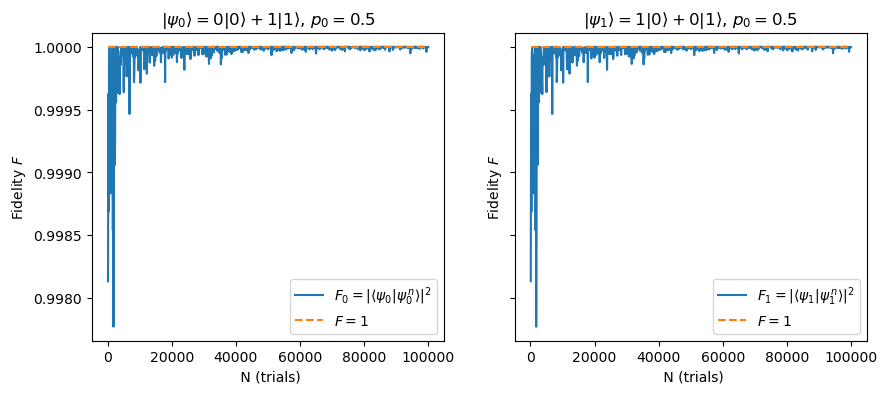

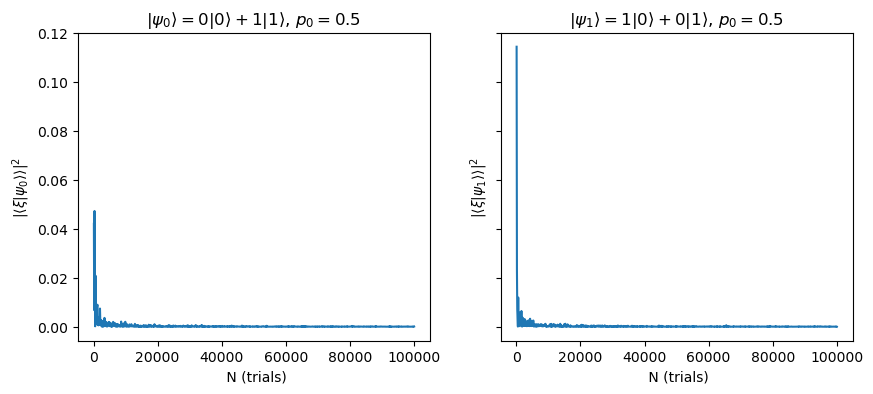

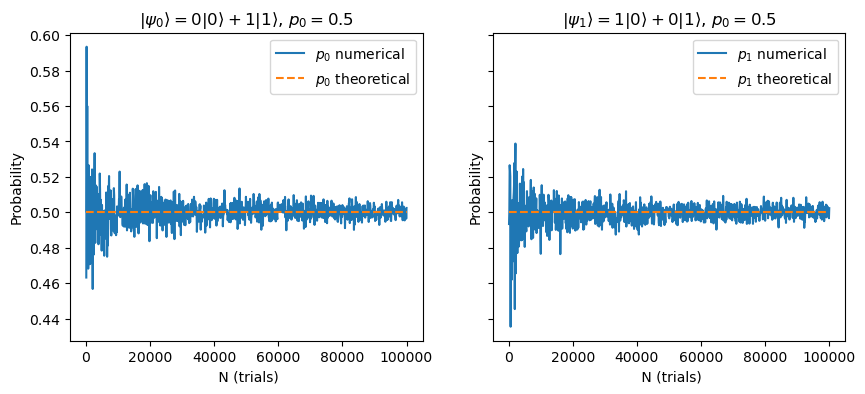

In [20]:
coeff = [0,1,1,0] 
priors = [.5,.5]
trials = [100*(i+1) for i in range(1000)]

initial_states = Creating_states(Abstract=False, coeff = coeff)     # Creating the two states with these coefficients
psi0 = initial_states[0]
psi1 = initial_states[1]
scalar = abs(np.vdot(psi0,psi1))
print(f'overlap = {scalar}')

pfid  = [1 for i in trials]    # perfect fidelity of 1
output_f = [experiment_fid(i,coeff,priors,POVM_elts, M_inv)[0] for i in tqdm(trials)]
output_x = [experiment_fid(i,coeff,priors,POVM_elts, M_inv)[1] for i in tqdm(trials)]
output_c = [experiment_fid(i,coeff,priors,POVM_elts, M_inv)[2] for i in tqdm(trials)]
output_psi = [experiment_fid(i,coeff,priors,POVM_elts, M_inv)[3] for i in tqdm(trials)]
output_p = [experiment_fid(i,coeff,priors,POVM_elts, M_inv)[4] for i in tqdm(trials)]
outputf = list(map(list, zip(*output_f))) # transpose of output_f
outputx = list(map(list, zip(*output_x))) # transpose of output_x
outputc = list(map(list, zip(*output_c))) # transpose of output_c
outputpsi = list(map(list, zip(*output_psi))) # transpose of output_psi
outputp = list(map(list, zip(*output_p))) # transpose of output_p


fig_a, (ax1a, ax2a) = plt.subplots(1,2, figsize=(10,4), sharey=True)
ax1a.plot(trials, outputf[0], label=r'$F_0=|\langle \psi_0|\psi_0^{\,n}\rangle|^2$')
ax1a.plot(trials , pfid, "--", label=r'$F=1$')
ax1a.set_xlabel(' N (trials)')
ax1a.set_ylabel(r'Fidelity $F$')
ax1a.set_title(r'$|\psi_0\rangle ={}|0\rangle+{}|1\rangle $, $p_0={}$'.format(round(coeff[0],1), round(coeff[1],1), priors[0]))
ax1a.legend(loc='best')
ax2a.plot(trials, outputf[1], label=r'$F_1=|\langle \psi_1|\psi_1^{\,n}\rangle|^2$')
ax2a.plot(trials , pfid, "--", label=r'$F=1$')
ax2a.set_xlabel(' N (trials)')
ax2a.set_ylabel(r'Fidelity $F$')
ax2a.set_title(r'$|\psi_1\rangle ={}|0\rangle+{}|1\rangle $, $p_0={}$'.format(round(coeff[2],1), round(coeff[3],1), priors[1]))
ax2a.legend(loc='best')

fig_b, (ax1b, ax2b) = plt.subplots(1,2, figsize=(10,4), sharey=True)
ax1b.plot(trials, outputx[0], label=r'$|\langle \xi|\psi_0\rangle\rangle|^2$')
#ax1b.plot(trials , pfid, "--", label=r'$F=1$')
ax1b.set_xlabel(' N (trials)')
ax1b.set_ylabel(r'$|\langle \xi|\psi_0\rangle\rangle|^2$')
ax1b.set_title(r'$|\psi_0\rangle ={}|0\rangle+{}|1\rangle $, $p_0={}$'.format(round(coeff[0],1), round(coeff[1],1), priors[0]))
#ax1b.legend(loc='best')
ax2b.plot(trials, outputx[1], label=r'$|\langle \xi|\psi_1\rangle\rangle|^2$')
#ax2b.plot(trials , pfid, "--", label=r'$F=1$')
ax2b.set_xlabel(' N (trials)')
ax2b.set_ylabel(r'$|\langle \xi|\psi_1\rangle\rangle|^2$')
ax2b.set_title(r'$|\psi_1\rangle ={}|0\rangle+{}|1\rangle $, $p_0={}$'.format(round(coeff[2],1), round(coeff[3],1), priors[1]))
#ax2b.legend(loc='best')

p0trials  = [priors[0] for i in trials] 
p1trials  = [priors[1] for i in trials] 
fig_c, (ax1c, ax2c) = plt.subplots(1,2, figsize=(10,4), sharey=True)
ax1c.plot(trials, outputp[0], label=r'$p_{0}$ numerical')
ax1c.plot(trials, p0trials, '--', label=r'$p_{0}$ theoretical')
ax2c.plot(trials, outputp[1], label=r'$p_{1}$ numerical')
ax2c.plot(trials, p1trials, '--', label=r'$p_{1}$ theoretical')
ax1c.set_xlabel(' N (trials)')
ax2c.set_xlabel(' N (trials)')
ax1c.set_ylabel(r'Probability')
ax2c.set_ylabel(r'Probability')
ax1c.legend(loc='best')
ax2c.legend(loc='best')
ax1c.set_title(r'$|\psi_0\rangle ={}|0\rangle+{}|1\rangle $, $p_0={}$'.format(round(coeff[0],1), round(coeff[1],1), priors[0]))
ax2c.set_title(r'$|\psi_1\rangle ={}|0\rangle+{}|1\rangle $, $p_0={}$'.format(round(coeff[2],1), round(coeff[3],1), priors[1]))

plt.show()

overlap = 1


100%|██████████| 1000/1000 [00:24<00:00, 41.27it/s]


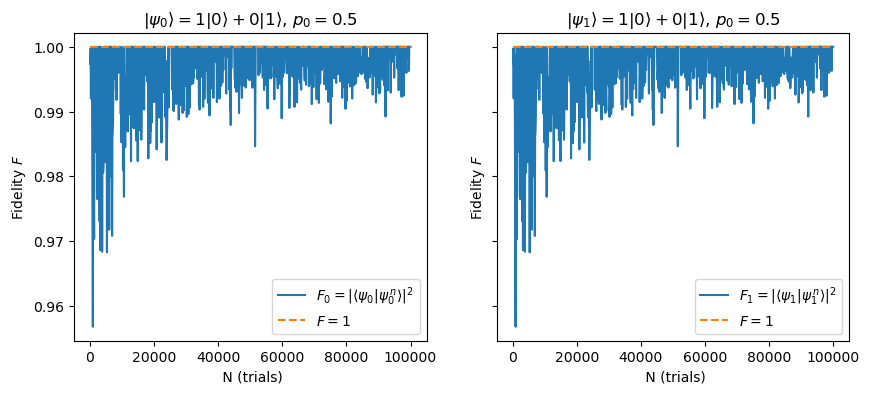

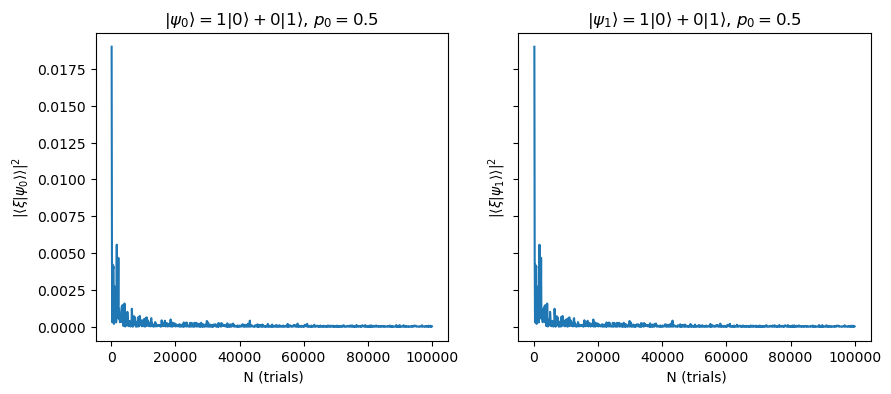

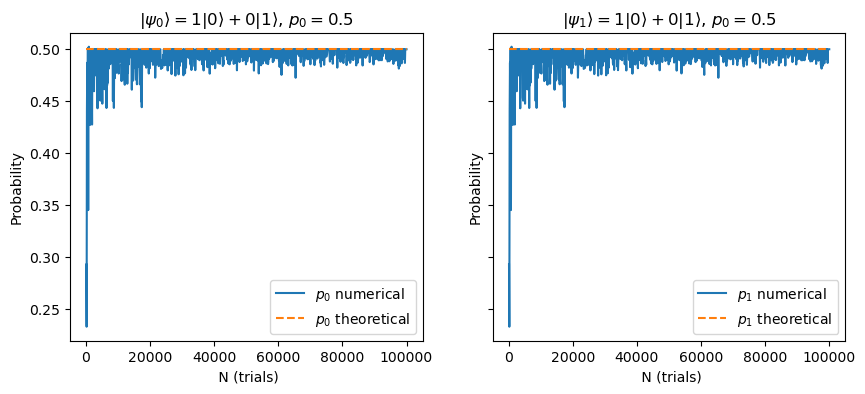

In [21]:
coeff = [1,0,1,0] 
priors = [.5,.5]
trials = [100*(i+1) for i in range(1000)]

initial_states = Creating_states(Abstract=False, coeff = coeff)     # Creating the two states with these coefficients
psi0 = initial_states[0]
psi1 = initial_states[1]
scalar = abs(np.vdot(psi0,psi1))
print(f'overlap = {scalar}')


pfid  = [1 for i in trials]    # perfect fidelity of 1
output_f = [experiment_fid(i,coeff,priors,POVM_elts, M_inv)[0] for i in tqdm(trials)]
output_x = [experiment_fid(i,coeff,priors,POVM_elts, M_inv)[1] for i in tqdm(trials)]
output_c = [experiment_fid(i,coeff,priors,POVM_elts, M_inv)[2] for i in tqdm(trials)]
output_psi = [experiment_fid(i,coeff,priors,POVM_elts, M_inv)[3] for i in tqdm(trials)]
output_p = [experiment_fid(i,coeff,priors,POVM_elts, M_inv)[4] for i in tqdm(trials)]
outputf = list(map(list, zip(*output_f))) # transpose of output_f
outputx = list(map(list, zip(*output_x))) # transpose of output_x
outputc = list(map(list, zip(*output_c))) # transpose of output_c
outputpsi = list(map(list, zip(*output_psi))) # transpose of output_psi
outputp = list(map(list, zip(*output_p))) # transpose of output_p


fig_a, (ax1a, ax2a) = plt.subplots(1,2, figsize=(10,4), sharey=True)

ax1a.plot(trials, outputf[0], label=r'$F_0=|\langle \psi_0|\psi_0^{\,n}\rangle|^2$')
ax1a.plot(trials , pfid, "--", label=r'$F=1$')
ax1a.set_xlabel(' N (trials)')
ax1a.set_ylabel(r'Fidelity $F$')
ax1a.set_title(r'$|\psi_0\rangle ={}|0\rangle+{}|1\rangle $, $p_0={}$'.format(round(coeff[0],1), round(coeff[1],1), priors[0]))
ax1a.legend(loc='best')

ax2a.plot(trials, outputf[1], label=r'$F_1=|\langle \psi_1|\psi_1^{\,n}\rangle|^2$')
ax2a.plot(trials , pfid, "--", label=r'$F=1$')
ax2a.set_xlabel(' N (trials)')
ax2a.set_ylabel(r'Fidelity $F$')
ax2a.set_title(r'$|\psi_1\rangle ={}|0\rangle+{}|1\rangle $, $p_0={}$'.format(round(coeff[2],1), round(coeff[3],1), priors[1]))
ax2a.legend(loc='best')

fig_b, (ax1b, ax2b) = plt.subplots(1,2, figsize=(10,4), sharey=True)

ax1b.plot(trials, outputx[0], label=r'$|\langle \xi|\psi_0\rangle\rangle|^2$')
#ax1b.plot(trials , pfid, "--", label=r'$F=1$')
ax1b.set_xlabel(' N (trials)')
ax1b.set_ylabel(r'$|\langle \xi|\psi_0\rangle\rangle|^2$')
ax1b.set_title(r'$|\psi_0\rangle ={}|0\rangle+{}|1\rangle $, $p_0={}$'.format(round(coeff[0],1), round(coeff[1],1), priors[0]))
#ax1b.legend(loc='best')

ax2b.plot(trials, outputx[1], label=r'$|\langle \xi|\psi_1\rangle\rangle|^2$')
#ax2b.plot(trials , pfid, "--", label=r'$F=1$')
ax2b.set_xlabel(' N (trials)')
ax2b.set_ylabel(r'$|\langle \xi|\psi_1\rangle\rangle|^2$')
ax2b.set_title(r'$|\psi_1\rangle ={}|0\rangle+{}|1\rangle $, $p_0={}$'.format(round(coeff[2],1), round(coeff[3],1), priors[1]))
#ax2b.legend(loc='best')

p0trials  = [priors[0] for i in trials] 
p1trials  = [priors[1] for i in trials] 
fig_c, (ax1c, ax2c) = plt.subplots(1,2, figsize=(10,4), sharey=True)
ax1c.plot(trials, outputp[0], label=r'$p_{0}$ numerical')
ax1c.plot(trials, p0trials, '--', label=r'$p_{0}$ theoretical')
ax2c.plot(trials, outputp[1], label=r'$p_{1}$ numerical')
ax2c.plot(trials, p1trials, '--', label=r'$p_{1}$ theoretical')
ax1c.set_xlabel(' N (trials)')
ax2c.set_xlabel(' N (trials)')
ax1c.set_ylabel(r'Probability')
ax2c.set_ylabel(r'Probability')
ax1c.legend(loc='best')
ax2c.legend(loc='best')
ax1c.set_title(r'$|\psi_0\rangle ={}|0\rangle+{}|1\rangle $, $p_0={}$'.format(round(coeff[0],1), round(coeff[1],1), priors[0]))
ax2c.set_title(r'$|\psi_1\rangle ={}|0\rangle+{}|1\rangle $, $p_0={}$'.format(round(coeff[2],1), round(coeff[3],1), priors[1]))

plt.show()

overlap = 0.7071067811865475


100%|██████████| 1000/1000 [00:20<00:00, 49.96it/s]


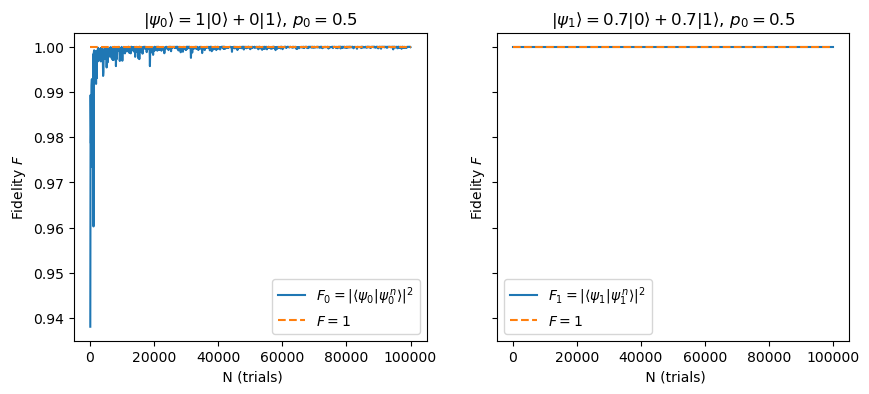

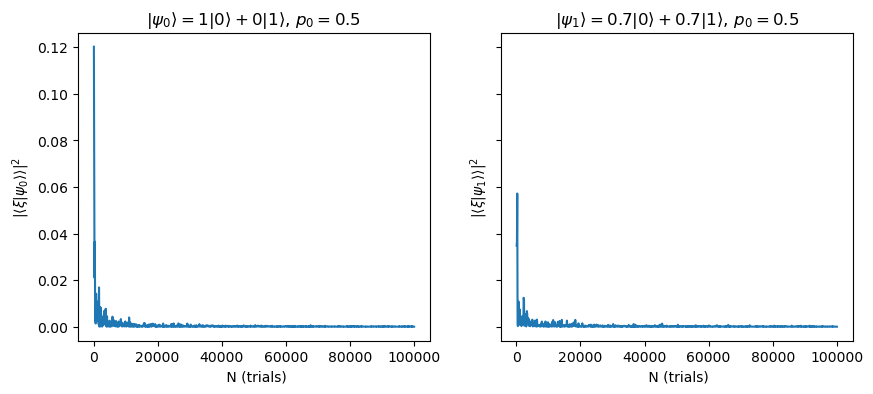

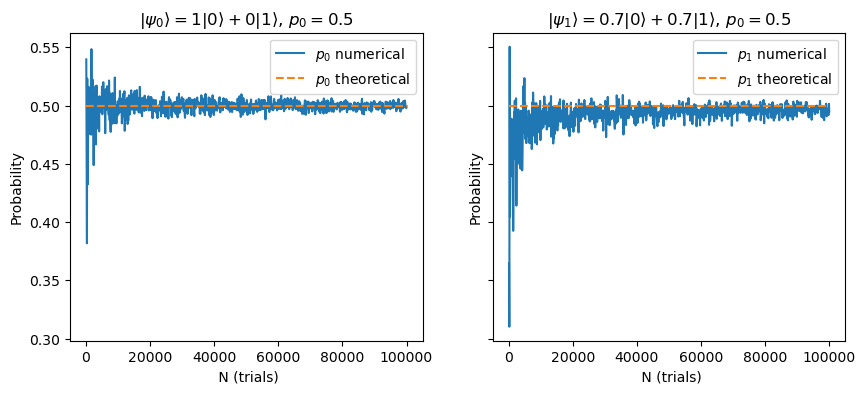

In [22]:
coeff = [1,0,1/(2**.5),1/(2**.5)] 
priors = [.5,.5]
trials = [100*(i+1) for i in range(1000)]

initial_states = Creating_states(Abstract=False, coeff = coeff)     # Creating the two states with these coefficients
psi0 = initial_states[0]
psi1 = initial_states[1]
scalar = abs(np.vdot(psi0,psi1))
print(f'overlap = {scalar}')

pfid  = [1 for i in trials]    # perfect fidelity of 1
output_f = [experiment_fid(i,coeff,priors,POVM_elts, M_inv)[0] for i in tqdm(trials)]
output_x = [experiment_fid(i,coeff,priors,POVM_elts, M_inv)[1] for i in tqdm(trials)]
output_c = [experiment_fid(i,coeff,priors,POVM_elts, M_inv)[2] for i in tqdm(trials)]
output_psi = [experiment_fid(i,coeff,priors,POVM_elts, M_inv)[3] for i in tqdm(trials)]
output_p = [experiment_fid(i,coeff,priors,POVM_elts, M_inv)[4] for i in tqdm(trials)]
outputf = list(map(list, zip(*output_f))) # transpose of output_f
outputx = list(map(list, zip(*output_x))) # transpose of output_x
outputc = list(map(list, zip(*output_c))) # transpose of output_c
outputpsi = list(map(list, zip(*output_psi))) # transpose of output_psi
outputp = list(map(list, zip(*output_p))) # transpose of output_p


fig_a, (ax1a, ax2a) = plt.subplots(1,2, figsize=(10,4), sharey=True)

ax1a.plot(trials, outputf[0], label=r'$F_0=|\langle \psi_0|\psi_0^{\,n}\rangle|^2$')
ax1a.plot(trials , pfid, "--", label=r'$F=1$')
ax1a.set_xlabel(' N (trials)')
ax1a.set_ylabel(r'Fidelity $F$')
ax1a.set_title(r'$|\psi_0\rangle ={}|0\rangle+{}|1\rangle $, $p_0={}$'.format(round(coeff[0],1), round(coeff[1],1), priors[0]))
ax1a.legend(loc='best')

ax2a.plot(trials, outputf[1], label=r'$F_1=|\langle \psi_1|\psi_1^{\,n}\rangle|^2$')
ax2a.plot(trials , pfid, "--", label=r'$F=1$')
ax2a.set_xlabel(' N (trials)')
ax2a.set_ylabel(r'Fidelity $F$')
ax2a.set_title(r'$|\psi_1\rangle ={}|0\rangle+{}|1\rangle $, $p_0={}$'.format(round(coeff[2],1), round(coeff[3],1), priors[1]))
ax2a.legend(loc='best')

fig_b, (ax1b, ax2b) = plt.subplots(1,2, figsize=(10,4), sharey=True)

ax1b.plot(trials, outputx[0], label=r'$|\langle \xi|\psi_0\rangle\rangle|^2$')
#ax1b.plot(trials , pfid, "--", label=r'$F=1$')
ax1b.set_xlabel(' N (trials)')
ax1b.set_ylabel(r'$|\langle \xi|\psi_0\rangle\rangle|^2$')
ax1b.set_title(r'$|\psi_0\rangle ={}|0\rangle+{}|1\rangle $, $p_0={}$'.format(round(coeff[0],1), round(coeff[1],1), priors[0]))
#ax1b.legend(loc='best')

ax2b.plot(trials, outputx[1], label=r'$|\langle \xi|\psi_1\rangle\rangle|^2$')
#ax2b.plot(trials , pfid, "--", label=r'$F=1$')
ax2b.set_xlabel(' N (trials)')
ax2b.set_ylabel(r'$|\langle \xi|\psi_1\rangle\rangle|^2$')
ax2b.set_title(r'$|\psi_1\rangle ={}|0\rangle+{}|1\rangle $, $p_0={}$'.format(round(coeff[2],1), round(coeff[3],1), priors[1]))
#ax2b.legend(loc='best')

p0trials  = [priors[0] for i in trials] 
p1trials  = [priors[1] for i in trials] 
fig_c, (ax1c, ax2c) = plt.subplots(1,2, figsize=(10,4), sharey=True)
ax1c.plot(trials, outputp[0], label=r'$p_{0}$ numerical')
ax1c.plot(trials, p0trials, '--', label=r'$p_{0}$ theoretical')
ax2c.plot(trials, outputp[1], label=r'$p_{1}$ numerical')
ax2c.plot(trials, p1trials, '--', label=r'$p_{1}$ theoretical')
ax1c.set_xlabel(' N (trials)')
ax2c.set_xlabel(' N (trials)')
ax1c.set_ylabel(r'Probability')
ax2c.set_ylabel(r'Probability')
ax1c.legend(loc='best')
ax2c.legend(loc='best')
ax1c.set_title(r'$|\psi_0\rangle ={}|0\rangle+{}|1\rangle $, $p_0={}$'.format(round(coeff[0],1), round(coeff[1],1), priors[0]))
ax2c.set_title(r'$|\psi_1\rangle ={}|0\rangle+{}|1\rangle $, $p_0={}$'.format(round(coeff[2],1), round(coeff[3],1), priors[1]))

plt.show()

overlap = 1.0000000000000002


100%|██████████| 1000/1000 [00:26<00:00, 37.43it/s]


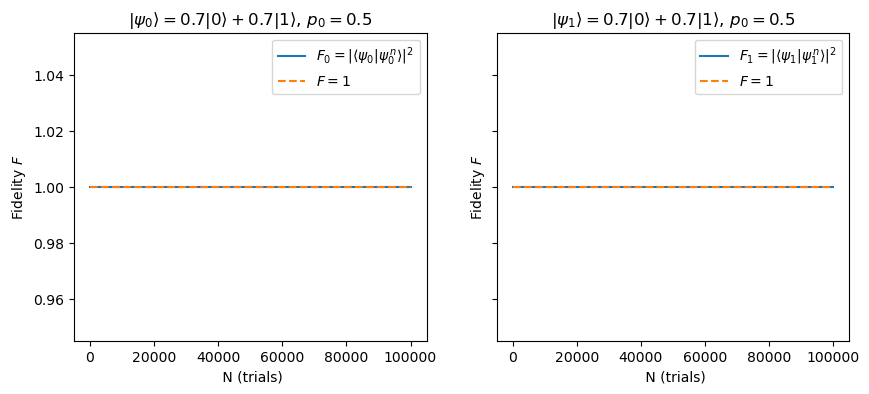

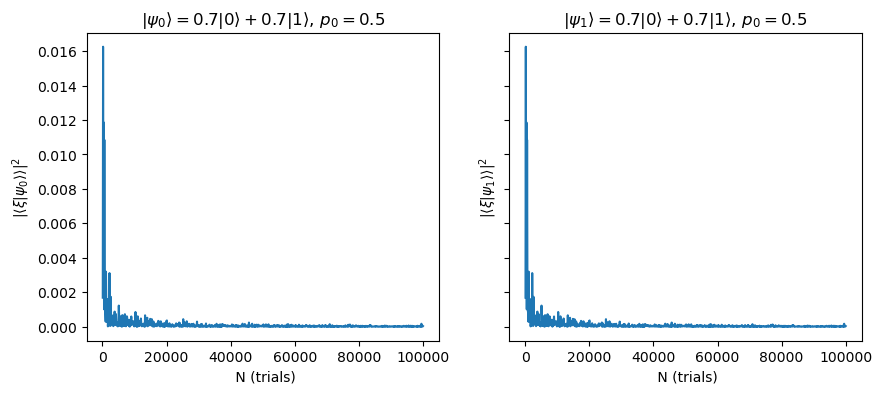

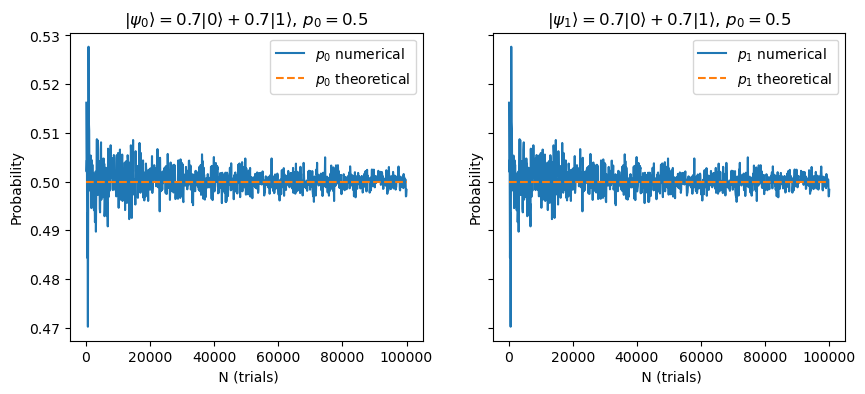

In [23]:
coeff = [(0.5)**(.5),(0.5)**(.5),(0.5)**(.5),(0.5)**(.5)] 
priors = [.5,.5]
trials = [100*(i+1) for i in range(1000)]

initial_states = Creating_states(Abstract=False, coeff = coeff)     # Creating the two states with these coefficients
psi0 = initial_states[0]
psi1 = initial_states[1]
scalar = abs(np.vdot(psi0,psi1))
print(f'overlap = {scalar}')


pfid  = [1 for i in trials]    # perfect fidelity of 1
output_f = [experiment_fid(i,coeff,priors,POVM_elts, M_inv)[0] for i in tqdm(trials)]
output_x = [experiment_fid(i,coeff,priors,POVM_elts, M_inv)[1] for i in tqdm(trials)]
output_c = [experiment_fid(i,coeff,priors,POVM_elts, M_inv)[2] for i in tqdm(trials)]
output_psi = [experiment_fid(i,coeff,priors,POVM_elts, M_inv)[3] for i in tqdm(trials)]
output_p = [experiment_fid(i,coeff,priors,POVM_elts, M_inv)[4] for i in tqdm(trials)]
outputf = list(map(list, zip(*output_f))) # transpose of output_f
outputx = list(map(list, zip(*output_x))) # transpose of output_x
outputc = list(map(list, zip(*output_c))) # transpose of output_c
outputpsi = list(map(list, zip(*output_psi))) # transpose of output_psi
outputp = list(map(list, zip(*output_p))) # transpose of output_p


fig_a, (ax1a, ax2a) = plt.subplots(1,2, figsize=(10,4), sharey=True)

ax1a.plot(trials, outputf[0], label=r'$F_0=|\langle \psi_0|\psi_0^{\,n}\rangle|^2$')
ax1a.plot(trials , pfid, "--", label=r'$F=1$')
ax1a.set_xlabel(' N (trials)')
ax1a.set_ylabel(r'Fidelity $F$')
ax1a.set_title(r'$|\psi_0\rangle ={}|0\rangle+{}|1\rangle $, $p_0={}$'.format(round(coeff[0],1), round(coeff[1],1), priors[0]))
ax1a.legend(loc='best')

ax2a.plot(trials, outputf[1], label=r'$F_1=|\langle \psi_1|\psi_1^{\,n}\rangle|^2$')
ax2a.plot(trials , pfid, "--", label=r'$F=1$')
ax2a.set_xlabel(' N (trials)')
ax2a.set_ylabel(r'Fidelity $F$')
ax2a.set_title(r'$|\psi_1\rangle ={}|0\rangle+{}|1\rangle $, $p_0={}$'.format(round(coeff[2],1), round(coeff[3],1), priors[1]))
ax2a.legend(loc='best')

fig_b, (ax1b, ax2b) = plt.subplots(1,2, figsize=(10,4), sharey=True)

ax1b.plot(trials, outputx[0], label=r'$|\langle \xi|\psi_0\rangle\rangle|^2$')
#ax1b.plot(trials , pfid, "--", label=r'$F=1$')
ax1b.set_xlabel(' N (trials)')
ax1b.set_ylabel(r'$|\langle \xi|\psi_0\rangle\rangle|^2$')
ax1b.set_title(r'$|\psi_0\rangle ={}|0\rangle+{}|1\rangle $, $p_0={}$'.format(round(coeff[0],1), round(coeff[1],1), priors[0]))
#ax1b.legend(loc='best')

ax2b.plot(trials, outputx[1], label=r'$|\langle \xi|\psi_1\rangle\rangle|^2$')
#ax2b.plot(trials , pfid, "--", label=r'$F=1$')
ax2b.set_xlabel(' N (trials)')
ax2b.set_ylabel(r'$|\langle \xi|\psi_1\rangle\rangle|^2$')
ax2b.set_title(r'$|\psi_1\rangle ={}|0\rangle+{}|1\rangle $, $p_0={}$'.format(round(coeff[2],1), round(coeff[3],1), priors[1]))
#ax2b.legend(loc='best')

p0trials  = [priors[0] for i in trials] 
p1trials  = [priors[1] for i in trials] 
fig_c, (ax1c, ax2c) = plt.subplots(1,2, figsize=(10,4), sharey=True)
ax1c.plot(trials, outputp[0], label=r'$p_{0}$ numerical')
ax1c.plot(trials, p0trials, '--', label=r'$p_{0}$ theoretical')
ax2c.plot(trials, outputp[1], label=r'$p_{1}$ numerical')
ax2c.plot(trials, p1trials, '--', label=r'$p_{1}$ theoretical')
ax1c.set_xlabel(' N (trials)')
ax2c.set_xlabel(' N (trials)')
ax1c.set_ylabel(r'Probability')
ax2c.set_ylabel(r'Probability')
ax1c.legend(loc='best')
ax2c.legend(loc='best')
ax1c.set_title(r'$|\psi_0\rangle ={}|0\rangle+{}|1\rangle $, $p_0={}$'.format(round(coeff[0],1), round(coeff[1],1), priors[0]))
ax2c.set_title(r'$|\psi_1\rangle ={}|0\rangle+{}|1\rangle $, $p_0={}$'.format(round(coeff[2],1), round(coeff[3],1), priors[1]))

plt.show()

overlap = 0.4472135954999579


100%|██████████| 1000/1000 [00:33<00:00, 30.29it/s]


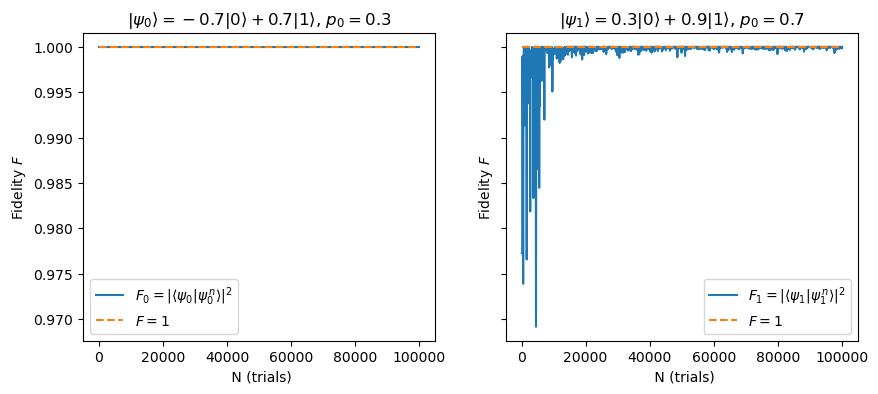

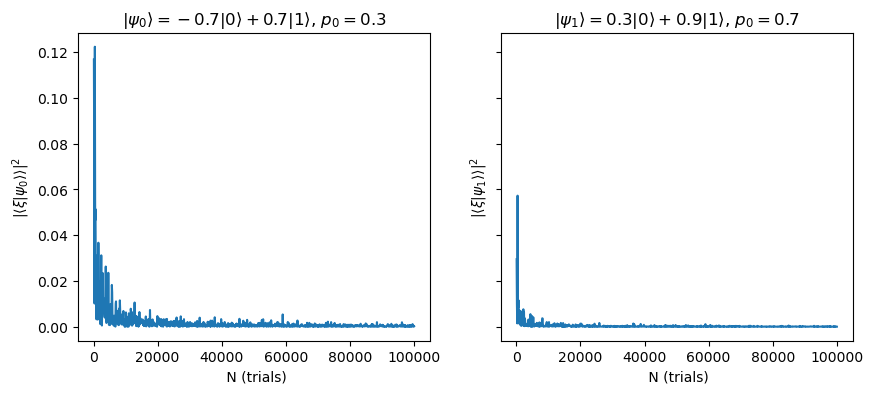

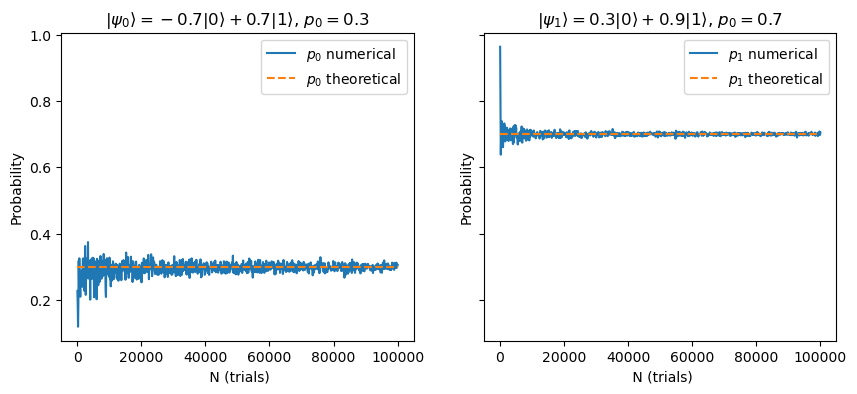

In [26]:
coeff = [-(0.5)**(.5),(0.5)**(.5),(0.1)**(.5),(0.9)**(.5)]
priors = [.3,.7]
trials = [100*(i+1) for i in range(1000)]

initial_states = Creating_states(Abstract=False, coeff = coeff)     # Creating the two states with these coefficients
psi0 = initial_states[0]
psi1 = initial_states[1]
scalar = abs(np.vdot(psi0,psi1))
print(f'overlap = {scalar}')


pfid  = [1 for i in trials]    # perfect fidelity of 1
output_f = [experiment_fid(i,coeff,priors,POVM_elts, M_inv)[0] for i in tqdm(trials)]
output_x = [experiment_fid(i,coeff,priors,POVM_elts, M_inv)[1] for i in tqdm(trials)]
output_c = [experiment_fid(i,coeff,priors,POVM_elts, M_inv)[2] for i in tqdm(trials)]
output_psi = [experiment_fid(i,coeff,priors,POVM_elts, M_inv)[3] for i in tqdm(trials)]
output_p = [experiment_fid(i,coeff,priors,POVM_elts, M_inv)[4] for i in tqdm(trials)]
outputf = list(map(list, zip(*output_f))) # transpose of output_f
outputx = list(map(list, zip(*output_x))) # transpose of output_x
outputc = list(map(list, zip(*output_c))) # transpose of output_c
outputpsi = list(map(list, zip(*output_psi))) # transpose of output_psi
outputp = list(map(list, zip(*output_p))) # transpose of output_p


fig_a, (ax1a, ax2a) = plt.subplots(1,2, figsize=(10,4), sharey=True)

ax1a.plot(trials, outputf[0], label=r'$F_0=|\langle \psi_0|\psi_0^{\,n}\rangle|^2$')
ax1a.plot(trials , pfid, "--", label=r'$F=1$')
ax1a.set_xlabel(' N (trials)')
ax1a.set_ylabel(r'Fidelity $F$')
ax1a.set_title(r'$|\psi_0\rangle ={}|0\rangle+{}|1\rangle $, $p_0={}$'.format(round(coeff[0],1), round(coeff[1],1), priors[0]))
ax1a.legend(loc='best')

ax2a.plot(trials, outputf[1], label=r'$F_1=|\langle \psi_1|\psi_1^{\,n}\rangle|^2$')
ax2a.plot(trials , pfid, "--", label=r'$F=1$')
ax2a.set_xlabel(' N (trials)')
ax2a.set_ylabel(r'Fidelity $F$')
ax2a.set_title(r'$|\psi_1\rangle ={}|0\rangle+{}|1\rangle $, $p_0={}$'.format(round(coeff[2],1), round(coeff[3],1), priors[1]))
ax2a.legend(loc='best')

fig_b, (ax1b, ax2b) = plt.subplots(1,2, figsize=(10,4), sharey=True)

ax1b.plot(trials, outputx[0], label=r'$|\langle \xi|\psi_0\rangle\rangle|^2$')
#ax1b.plot(trials , pfid, "--", label=r'$F=1$')
ax1b.set_xlabel(' N (trials)')
ax1b.set_ylabel(r'$|\langle \xi|\psi_0\rangle\rangle|^2$')
ax1b.set_title(r'$|\psi_0\rangle ={}|0\rangle+{}|1\rangle $, $p_0={}$'.format(round(coeff[0],1), round(coeff[1],1), priors[0]))
#ax1b.legend(loc='best')

ax2b.plot(trials, outputx[1], label=r'$|\langle \xi|\psi_1\rangle\rangle|^2$')
#ax2b.plot(trials , pfid, "--", label=r'$F=1$')
ax2b.set_xlabel(' N (trials)')
ax2b.set_ylabel(r'$|\langle \xi|\psi_1\rangle\rangle|^2$')
ax2b.set_title(r'$|\psi_1\rangle ={}|0\rangle+{}|1\rangle $, $p_0={}$'.format(round(coeff[2],1), round(coeff[3],1), priors[1]))
#ax2b.legend(loc='best')

p0trials  = [priors[0] for i in trials] 
p1trials  = [priors[1] for i in trials] 
fig_c, (ax1c, ax2c) = plt.subplots(1,2, figsize=(10,4), sharey=True)
ax1c.plot(trials, outputp[0], label=r'$p_{0}$ numerical')
ax1c.plot(trials, p0trials, '--', label=r'$p_{0}$ theoretical')
ax2c.plot(trials, outputp[1], label=r'$p_{1}$ numerical')
ax2c.plot(trials, p1trials, '--', label=r'$p_{1}$ theoretical')
ax1c.set_xlabel(' N (trials)')
ax2c.set_xlabel(' N (trials)')
ax1c.set_ylabel(r'Probability')
ax2c.set_ylabel(r'Probability')
ax1c.legend(loc='best')
ax2c.legend(loc='best')
ax1c.set_title(r'$|\psi_0\rangle ={}|0\rangle+{}|1\rangle $, $p_0={}$'.format(round(coeff[0],1), round(coeff[1],1), priors[0]))
ax2c.set_title(r'$|\psi_1\rangle ={}|0\rangle+{}|1\rangle $, $p_0={}$'.format(round(coeff[2],1), round(coeff[3],1), priors[1]))

plt.show()